# Solar Neutrino Problem with Slab Approximation

Solved using slab approximation instead of Polarisation Vector

In [1]:
#Libraries
import numpy as np
from scipy.linalg import expm
from scipy.constants import physical_constants as pc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


plt.style.use(['classic',"seaborn-v0_8-dark"])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mcolors.TABLEAU_COLORS)
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 18
plt.rcParams["legend.frameon"]=True
plt.rcParams['lines.linewidth'] = 1.5

In [2]:
# Fundamental Constants
G_F = pc['Fermi coupling constant'][0]*1e-18 # eV^2 
N_A = pc['Avogadro constant'][0] # mol-1
hbar = pc['reduced Planck constant'][0]/pc['electron volt'][0] # eV.s
c = pc['speed of light in vacuum'][0] # m.s-1

# Flavour Specific Constants
del_m2_31=2.5*1e-3
del_m2_21=7.53*1e-5
theta_31=np.arcsin(np.sqrt(2.18*1e-2))
theta_21=np.arcsin(np.sqrt(0.307))

# Conversion Factors
eV_to_1_by_m = pc['electron volt-inverse meter relationship'][0]
eV_to_1_by_km = eV_to_1_by_m*1e3
one_by_cm3_to_eV3 = (1.973*1e-5)**3
erg_to_MeV = 6.2415*1e5

In [3]:
R_sol = 6.96340*1e8 #m
R_sol= R_sol*(8*1e5) #eV⁻¹

def N(r):
    return 245*N_A*np.exp(-r*10.45/R_sol)*one_by_cm3_to_eV3  # eV3

In [4]:
# Matter Potential
def A_cc(n_e, E):
    return 2*np.sqrt(2)*G_F*n_e*E

# Effective mass squared difference in matter
def del_m2_eff(del_m2, theta, A_cc):
    x = np.sqrt((del_m2*np.cos(2*theta) - A_cc)**2 + (del_m2*np.sin(2*theta))** 2)
    return x

# Effective mixing angle
def theta_eff(del_m2, theta, A_cc):
    num = del_m2*np.sin(2*theta)
    den = del_m2*np.cos(2*theta) - A_cc
    return 0.5*np.arctan2(num,den)

In [5]:
def slab_unitary(del_m2_m, theta_m, E, delta_x):
    # Phase
    phi = del_m2_m * delta_x / (4 * E)

    sin2theta = np.sin(2 * theta_m)
    cos2theta = np.cos(2 * theta_m)
    n = np.array([sin2theta, 0.0, -cos2theta])

    # Pauli matrices
    sigma = [
        np.array([[0, 1], [1, 0]], dtype=complex),     # sigma_1
        np.array([[0, -1j], [1j, 0]], dtype=complex),  # sigma_2
        np.array([[1, 0], [0, -1]], dtype=complex)     # sigma_3
    ]

    # U = cosφ * I - i sinφ * (n . σ)
    U = np.cos(phi) * np.eye(2, dtype=complex)
    for i in range(3):
        U -= 1j * np.sin(phi) * n[i] * sigma[i]
    return U
    
    return U

In [6]:
def solar_solver_slab(E_mev, r_i=0.0, r_f=1.0, n_slabs=10000):
    E = E_mev * 1e6
    r_frac_edges = np.linspace(r_i, r_f, n_slabs + 1)
    r_frac_mid   = 0.5 * (r_frac_edges[:-1] + r_frac_edges[1:])
    Δr = (r_f - r_i) * R_sol / n_slabs

    psi = np.array([1.0 + 0j, 0.0 + 0j])  # ν_e state
    Pee_array = np.zeros(n_slabs)
    r_frac_array = np.zeros(n_slabs)

    for idx, rf in enumerate(r_frac_mid):
        A = A_cc(N(rf*R_sol), E)
        delm2_m = del_m2_eff(del_m2_21, theta_21, A)
        theta_m = theta_eff(del_m2_21, theta_21, A)

        U = slab_unitary(delm2_m, theta_m, E, Δr)
        psi = U @ psi

        r_frac_array[idx] = rf
        Pee_array[idx] = np.abs(psi[0])**2

    return r_frac_array, Pee_array

In [12]:
def plot_solar_slab(E_mev):
    r_frac, Pee = solar_solver_slab(E_mev)

    Pee_high = np.sin(theta_21)**2
    Pee_low = 1.0 - 0.5 * np.sin(2*theta_21)**2

    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(r_frac, Pee, label=f'E = {E_mev:.1f} MeV', color='b', alpha = 0.8)
    if E_mev > 3.0:
        ax.axhline(Pee_high, color='r', linestyle='--', label=r'High-E limit: $\sin^2 \theta$')
    else:
        ax.axhline(Pee_low, color='g', linestyle='--', label=r'Low-E limit: $1 - \frac{1}{2} \sin^2 2\theta$')
        ax.set_xlim(0.9,1.00)
    ax.set_xlabel(r'$r/R_{\odot}$')
    ax.set_ylabel(r'$P_{ee}$')
    ax.set_title(r'Survival Probability - P($\nu_e \rightarrow \nu_e$)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

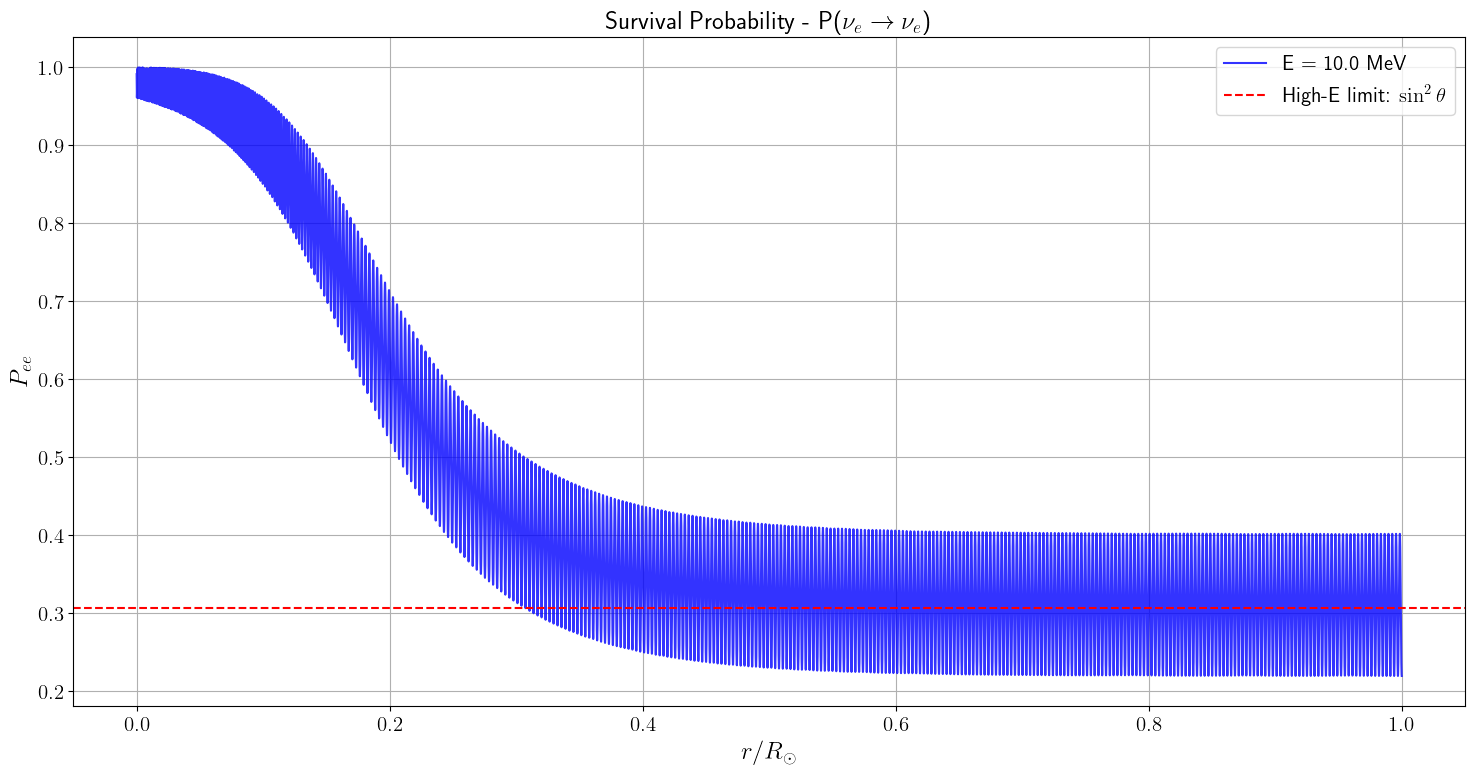

In [13]:
plot_solar_slab(10) # 10 MeV

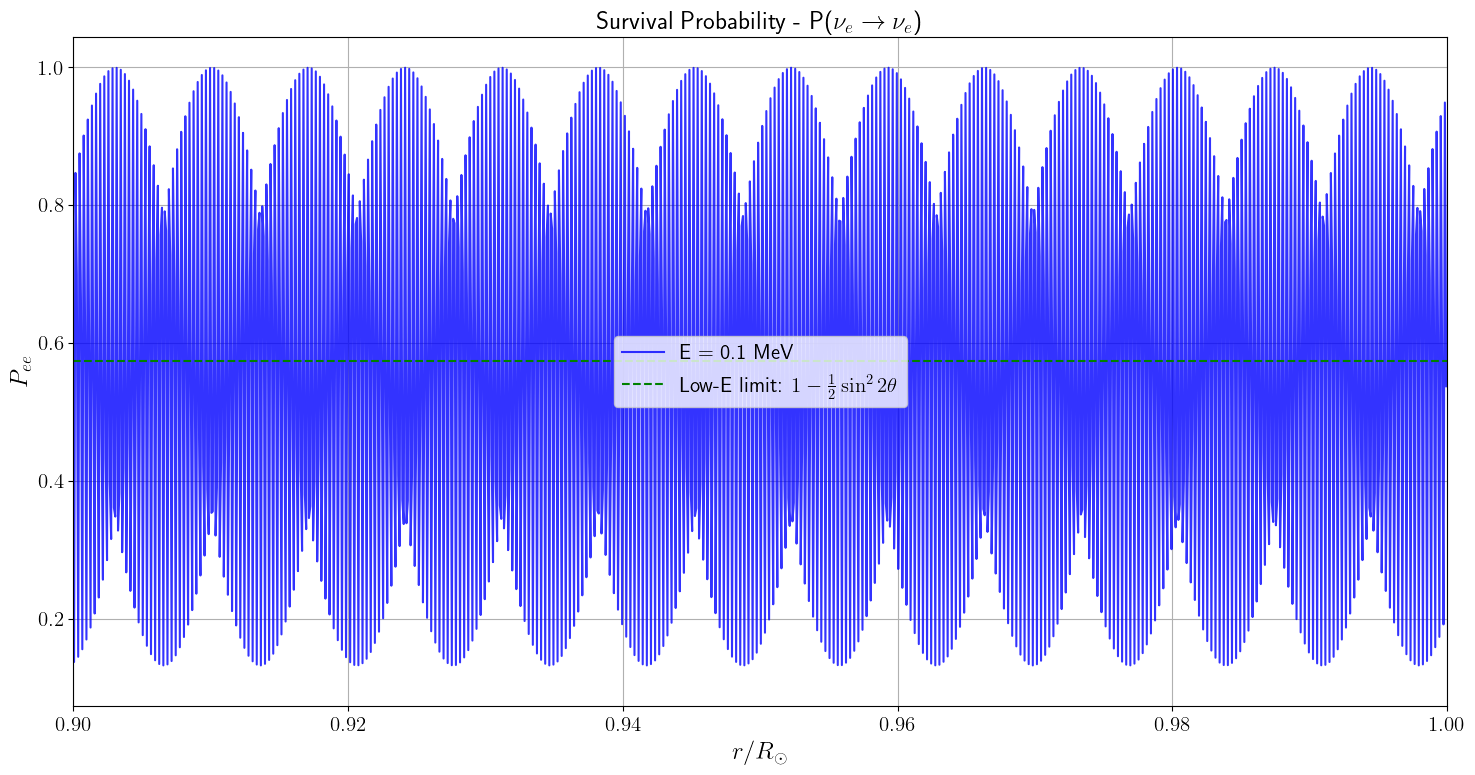

In [9]:
plot_solar_slab(0.1) # o.1 MeV

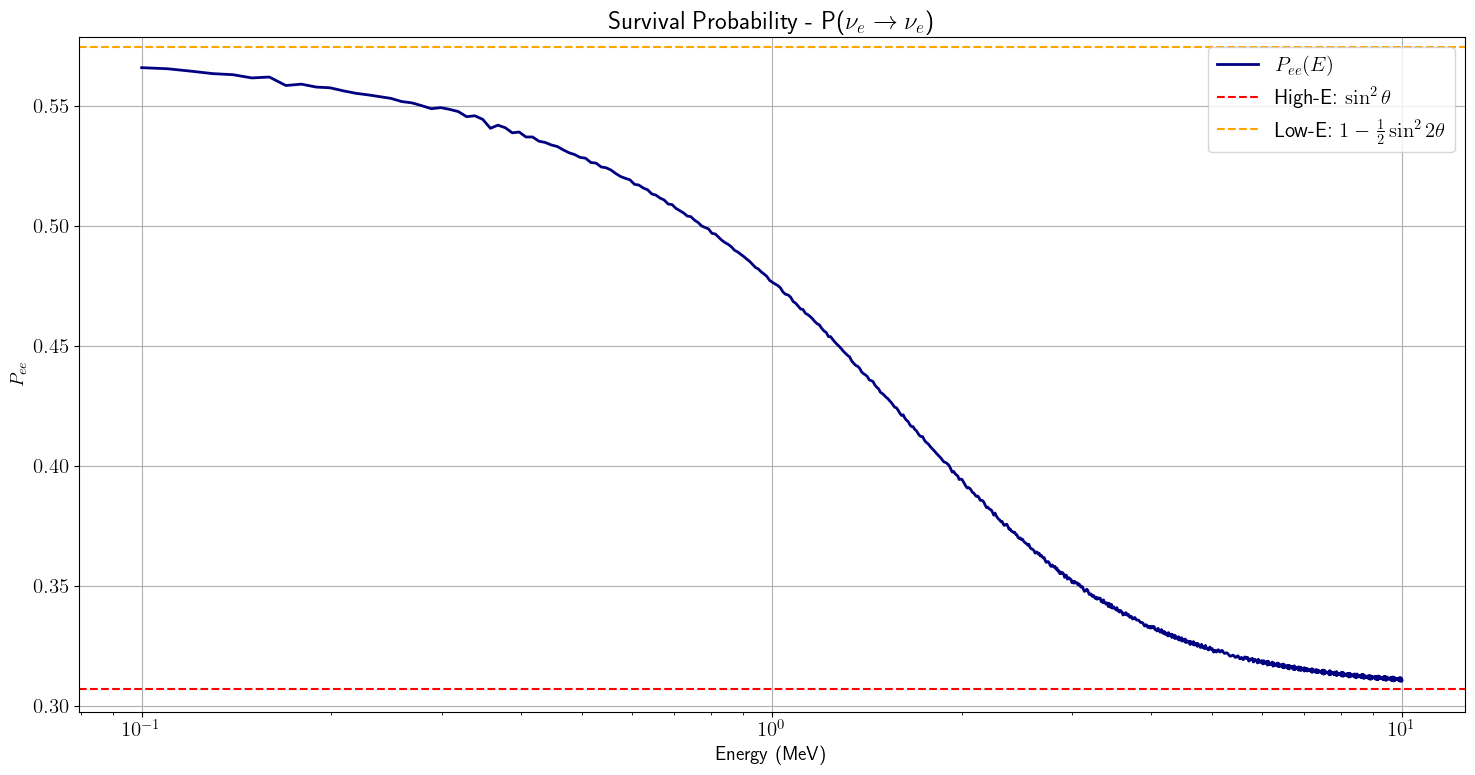

In [ ]:
# Plot of P_ee with varying E
E_vals = np.linspace(0.1, 10, 1000)
Pee_vals = []

for E in E_vals:
    r_frac, Pee_profile = solar_solver_slab(E)
    mask = (r_frac >= 0.9)
    Pee_vals.append(np.mean(Pee_profile[mask]))  # Average over the selected range

# Plotting the updated average Pee vs Energy
plt.figure(figsize=(15,8))
plt.plot(E_vals, Pee_vals, color='navy', lw=2, label=r'$P_{ee}(E)$')

Pee_high = np.sin(theta_21)**2
Pee_low = 1 - 0.5 * np.sin(2*theta_21)**2
plt.axhline(Pee_high, color='red', ls='--', label=r'High-E: $\sin^2 \theta$')
plt.axhline(Pee_low, color='orange', ls='--', label=r'Low-E: $1 - \frac{1}{2} \sin^2 2\theta$')

plt.xscale('log')
plt.xlabel('Energy (MeV)', fontsize=14)
plt.ylabel(r'$P_{ee}$', fontsize=14)
plt.title(r'Survival Probability - P($\nu_e \rightarrow \nu_e$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()